In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

In [8]:
smiles = 'CCC(NC(=O)c1scnc1C1CC1)C(=O)N1CCOCC1'
#smiles = 'c1c2ccccc2ccc1'

In [9]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

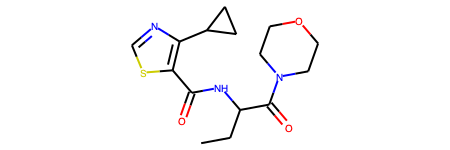

In [10]:
mol = Chem.MolFromSmiles(smiles)
mol

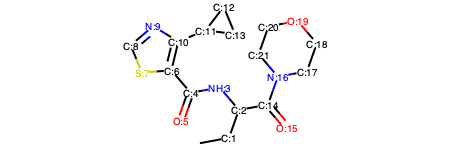

In [11]:
indexed_mol = mol_with_atom_index(mol)
indexed_mol

In [14]:
clusters = []
# find cluster of atoms that atoms in clusters are disjointed from the graph.
# atoms in clusters are disjointed from the graph.
# breaking the graph into 2 pieces
for bond in mol.GetBonds():
    a1 = bond.GetBeginAtom().GetIdx()
    a2 = bond.GetEndAtom().GetIdx()

    if not bond.IsInRing():
        print('Not In Ring', (a1, a2))
        clusters.append((a1, a2))
    else:
        print('in Ring', (a1, a2))

Not In Ring (0, 1)
Not In Ring (1, 2)
Not In Ring (2, 3)
Not In Ring (3, 4)
Not In Ring (4, 5)
Not In Ring (4, 6)
in Ring (6, 7)
in Ring (7, 8)
in Ring (8, 9)
in Ring (9, 10)
Not In Ring (10, 11)
in Ring (11, 12)
in Ring (12, 13)
Not In Ring (2, 14)
Not In Ring (14, 15)
Not In Ring (14, 16)
in Ring (16, 17)
in Ring (17, 18)
in Ring (18, 19)
in Ring (19, 20)
in Ring (20, 21)
in Ring (10, 6)
in Ring (13, 11)
in Ring (21, 16)


In [15]:
clusters

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (4, 6),
 (10, 11),
 (2, 14),
 (14, 15),
 (14, 16)]

In [17]:
ssr = [tuple(x) for x in Chem.GetSymmSSSR(mol)]
ssr

[(7, 6, 10, 9, 8), (12, 11, 13), (17, 18, 19, 20, 21, 16)]

In [55]:
new_mol = Chem.RWMol(mol)
for atom in new_mol.GetAtoms():
    print(atom.GetSymbol(), atom.GetIdx(), atom.GetAtomMapNum())

C 0 0
C 1 1
C 2 2
N 3 3
C 4 4
O 5 5
C 6 6
S 7 7
C 8 8
N 9 9
C 10 10
C 11 11
C 12 12
C 13 13
C 14 14
O 15 15
N 16 16
C 17 17
C 18 18
O 19 19
C 20 20
C 21 21


In [46]:
for atom in new_mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx())

In [47]:
for atom in new_mol.GetAtoms():
    print(atom.GetSymbol(), atom.GetIdx(), atom.GetAtomMapNum())

C 0 0
C 1 1
C 2 2
N 3 3
C 4 4
O 5 5
C 6 6
S 7 7
C 8 8
N 9 9
C 10 10
C 11 11
C 12 12
C 13 13
C 14 14
O 15 15
N 16 16
C 17 17
C 18 18
O 19 19
C 20 20
C 21 21


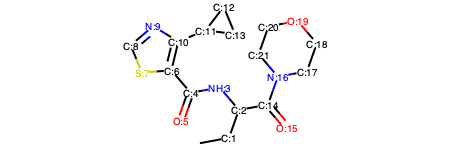

In [48]:
indexed_mol = mol_with_atom_index(new_mol)
indexed_mol

In [49]:
for atom in indexed_mol.GetAtoms():
    print(atom.GetIdx(), atom.GetSymbol(), atom.GetDegree())

0 C 1
1 C 2
2 C 3
3 N 2
4 C 3
5 O 1
6 C 3
7 S 2
8 C 2
9 N 2
10 C 3
11 C 3
12 C 2
13 C 2
14 C 3
15 O 1
16 N 3
17 C 2
18 C 2
19 O 2
20 C 2
21 C 2


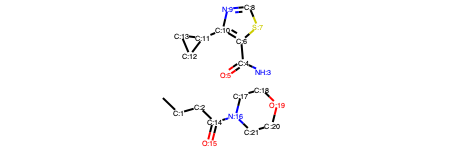

In [56]:
new_mol.RemoveBond(2, 3)
indexed_mol = mol_with_atom_index(new_mol)
indexed_mol

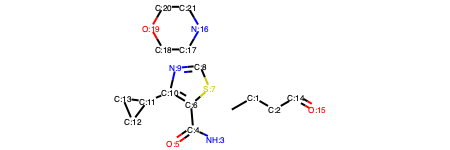

In [58]:
new_mol.RemoveBond(14, 16)
indexed_mol = mol_with_atom_index(new_mol)
indexed_mol

In [ ]:
new_mol

In [12]:
import rdkit
import rdkit.Chem as Chem
from collections import defaultdict

lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

idxfunc = lambda a: a.GetAtomMapNum() - 1


def set_atommap(mol, num=0):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(num)
    return mol


def get_mol(smiles):
    # Function to convert provided SMILES string to Mol object
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None: Chem.Kekulize(mol)
    return mol


def get_smiles(mol):
    return Chem.MolToSmiles(mol, kekuleSmiles=True)


def sanitize(mol, kekulize=True):
    try:
        smiles = get_smiles(mol) if kekulize else Chem.MolToSmiles(mol)
        mol = get_mol(smiles) if kekulize else Chem.MolFromSmiles(smiles)
    except:
        mol = None
    return mol


def is_aromatic_ring(mol):
    if mol.GetNumAtoms() == mol.GetNumBonds():
        aroma_bonds = [b for b in mol.GetBonds() if b.GetBondType() == Chem.rdchem.BondType.AROMATIC]
        return len(aroma_bonds) == mol.GetNumBonds()
    else:
        return False


def find_fragments(mol):
    # extract motif
    new_mol = Chem.RWMol(mol)
    for atom in new_mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())

    # break bonds to create fragments
    for bond in mol.GetBonds():
        if bond.IsInRing(): continue # not break bond if in a motif
        a1 = bond.GetBeginAtom()
        a2 = bond.GetEndAtom()

        # 2 adjacent rings. Already satisfied the motif extraction rules
        if a1.IsInRing() and a2.IsInRing():
            new_mol.RemoveBond(a1.GetIdx(), a2.GetIdx())

        # break bonds (u, v) where both u's and v's degree > 1
        # and either u or v is in ring
        elif a1.IsInRing() and a2.GetDegree() > 1:
            new_idx = new_mol.AddAtom(copy_atom(a1))
            new_mol.GetAtomWithIdx(new_idx).SetAtomMapNum(a1.GetIdx())
            new_mol.AddBond(new_idx, a2.GetIdx(), bond.GetBondType())
            new_mol.RemoveBond(a1.GetIdx(), a2.GetIdx())

        elif a2.IsInRing() and a1.GetDegree() > 1:
            new_idx = new_mol.AddAtom(copy_atom(a2))
            new_mol.GetAtomWithIdx(new_idx).SetAtomMapNum(a2.GetIdx())
            new_mol.AddBond(new_idx, a1.GetIdx(), bond.GetBondType())
            new_mol.RemoveBond(a1.GetIdx(), a2.GetIdx())

    new_mol = new_mol.GetMol() # get destructed mol
    new_smiles = Chem.MolToSmiles(new_mol) # periods to represent disjoint motifs

    # split fragments and convert into kekulized-format
    hopts = []
    for fragment in new_smiles.split('.'):
        fmol = Chem.MolFromSmiles(fragment) # to mol
        indices = set([atom.GetAtomMapNum() for atom in fmol.GetAtoms()])
        #if len(indices) == 0:
        #    print(Chem.MolToSmiles(mol))
        #print(indices, Chem.MolToSmiles(mol))
        fmol = get_clique_mol(mol, indices)
        fmol = sanitize(fmol, kekulize=False)
        fsmiles = Chem.MolToSmiles(fmol)
        hopts.append((fsmiles, indices))
    return hopts


def get_leaves(mol):
    leaf_atoms = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetDegree() == 1]

    clusters = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        if not bond.IsInRing():
            clusters.append(set([a1, a2]))

    rings = [set(x) for x in Chem.GetSymmSSSR(mol)]
    clusters.extend(rings)

    leaf_rings = []
    for r in rings:
        inters = [c for c in clusters if r != c and len(r & c) > 0]
        if len(inters) > 1: continue
        nodes = [i for i in r if mol.GetAtomWithIdx(i).GetDegree() == 2]
        leaf_rings.append(max(nodes))

    return leaf_atoms + leaf_rings


def atom_equal(a1, a2):
    return a1.GetSymbol() == a2.GetSymbol() and a1.GetFormalCharge() == a2.GetFormalCharge()


def bond_match(mol1, a1, b1, mol2, a2, b2):
    a1, b1 = mol1.GetAtomWithIdx(a1), mol1.GetAtomWithIdx(b1)
    a2, b2 = mol2.GetAtomWithIdx(a2), mol2.GetAtomWithIdx(b2)
    return atom_equal(a1, a2) and atom_equal(b1, b2)


def copy_atom(atom, atommap=True):
    # create a shallow copy of atom w/ symbol and formal charge
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    if atommap:
        new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom


# mol must be RWMol object
def get_sub_mol(mol, sub_atoms):
    new_mol = Chem.RWMol()
    atom_map = {}
    for idx in sub_atoms:
        atom = mol.GetAtomWithIdx(idx)
        atom_map[idx] = new_mol.AddAtom(atom)

    sub_atoms = set(sub_atoms)
    for idx in sub_atoms:
        a = mol.GetAtomWithIdx(idx)
        for b in a.GetNeighbors():
            if b.GetIdx() not in sub_atoms: continue
            bond = mol.GetBondBetweenAtoms(a.GetIdx(), b.GetIdx())
            bt = bond.GetBondType()
            if a.GetIdx() < b.GetIdx():  # each bond is enumerated twice
                new_mol.AddBond(atom_map[a.GetIdx()], atom_map[b.GetIdx()], bt)

    return new_mol.GetMol()


def copy_edit_mol(mol):
    # create a shallow copy of molecule
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    for atom in mol.GetAtoms():
        new_atom = copy_atom(atom)
        new_mol.AddAtom(new_atom)

    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
        # if bt == Chem.rdchem.BondType.AROMATIC and not aromatic:
        #    bt = Chem.rdchem.BondType.SINGLE
    return new_mol


def get_clique_mol(mol, atoms):
    smiles = Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True)
    new_mol = Chem.MolFromSmiles(smiles, sanitize=False)
    new_mol = copy_edit_mol(new_mol).GetMol()
    new_mol = sanitize(new_mol)
    # if tmp_mol is not None: new_mol = tmp_mol
    return new_mol


def get_assm_cands(mol, atoms, inter_label, cluster, inter_size):
    atoms = list(set(atoms))
    mol = get_clique_mol(mol, atoms)
    atom_map = [idxfunc(atom) for atom in mol.GetAtoms()]
    mol = set_atommap(mol)
    rank = Chem.CanonicalRankAtoms(mol, breakTies=False)
    rank = {x: y for x, y in zip(atom_map, rank)}

    pos, icls = zip(*inter_label)
    if inter_size == 1:
        cands = [pos[0]] + [x for x in cluster if rank[x] != rank[pos[0]]]

    elif icls[0] == icls[1]:  # symmetric case
        shift = cluster[inter_size - 1:] + cluster[:inter_size - 1]
        cands = zip(cluster, shift)
        cands = [pos] + [(x, y) for x, y in cands if
                         (rank[min(x, y)], rank[max(x, y)]) != (rank[min(pos)], rank[max(pos)])]
    else:
        shift = cluster[inter_size - 1:] + cluster[:inter_size - 1]
        cands = zip(cluster + shift, shift + cluster)
        cands = [pos] + [(x, y) for x, y in cands if (rank[x], rank[y]) != (rank[pos[0]], rank[pos[1]])]

    return cands


def get_inter_label(mol, atoms, inter_atoms, atom_cls):
    new_mol = get_clique_mol(mol, atoms)
    if new_mol.GetNumBonds() == 0:
        inter_atom = list(inter_atoms)[0]
        for a in new_mol.GetAtoms():
            a.SetAtomMapNum(0)
        return new_mol, [(inter_atom, Chem.MolToSmiles(new_mol))]

    inter_label = []
    for a in new_mol.GetAtoms():
        idx = idxfunc(a)
        if idx in inter_atoms and is_anchor(a, inter_atoms):
            inter_label.append((idx, get_anchor_smiles(new_mol, idx)))

    for a in new_mol.GetAtoms():
        idx = idxfunc(a)
        if idx in inter_atoms:
            a.SetAtomMapNum(1)
        elif len(atom_cls[idx]) > 1:
            a.SetAtomMapNum(2)
        else:
            a.SetAtomMapNum(0)

    return new_mol, inter_label


def is_anchor(atom, inter_atoms):
    for a in atom.GetNeighbors():
        if idxfunc(a) not in inter_atoms:
            return True
    return False


def get_anchor_smiles(mol, anchor, idxfunc=idxfunc):
    copy_mol = Chem.Mol(mol)
    for a in copy_mol.GetAtoms():
        idx = idxfunc(a)
        if idx == anchor:
            a.SetAtomMapNum(1)
        else:
            a.SetAtomMapNum(0)

    return get_smiles(copy_mol)


In [13]:
fragments = find_fragments(mol)

In [14]:
fragments

[('C[CH2:1][CH:2]([NH:3][C:4](=[O:5])[CH3:6])[C:14](=[O:15])[NH2:16]',
  {0, 1, 2, 3, 4, 5, 6, 14, 15, 16}),
 ('[CH2:11]1[CH2:12][CH2:13]1', {11, 12, 13}),
 ('[NH:16]1[CH2:17][CH2:18][O:19][CH2:20][CH2:21]1', {16, 17, 18, 19, 20, 21}),
 ('[CH:6]1:[S:7]:[CH:8]:[N:9]:[CH:10]:1', {6, 7, 8, 9, 10})]

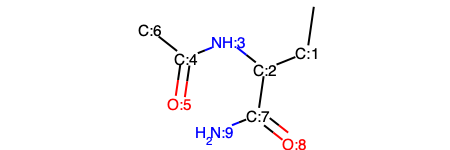

In [17]:
mol_with_atom_index(Chem.MolFromSmiles(fragments[0][0]))

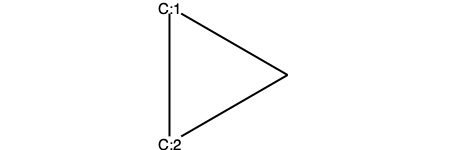

In [18]:
mol_with_atom_index(Chem.MolFromSmiles(fragments[1][0]))

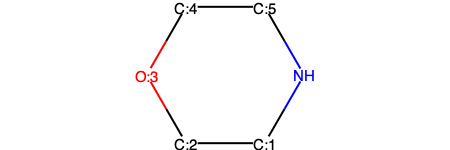

In [19]:
mol_with_atom_index(Chem.MolFromSmiles(fragments[2][0]))

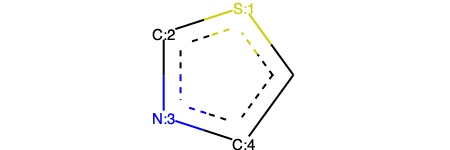

In [20]:
mol_with_atom_index(Chem.MolFromSmiles(fragments[3][0]))

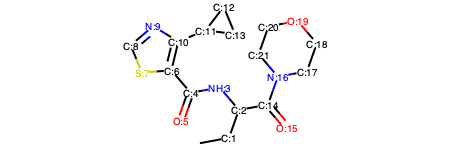

In [22]:
mol

In [26]:
def find_clusters(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:  # special case
        return [(0,)], [[0]]

    clusters = []
    # find cluster of atoms that atoms in clusters are disjointed from the graph.
    # atoms in clusters are disjointed from the graph.
    # breaking the graph into 2 pieces
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()

        if not bond.IsInRing():
            clusters.append((a1, a2))

    # find a smallest set of smallest rings (SSSR)        
    # after removing non-ring bonds, we have multi rings (cycles) in the graph.
    # The smallest rings are only valid clusters of atoms/vertices in a graph.
    ssr = [tuple(x) for x in Chem.GetSymmSSSR(mol)]
    clusters.extend(ssr)
    
    return clusters

In [28]:
clusters = find_clusters(mol)
clusters

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (4, 6),
 (10, 11),
 (2, 14),
 (14, 15),
 (14, 16),
 (7, 6, 10, 9, 8),
 (12, 11, 13),
 (17, 18, 19, 20, 21, 16)]

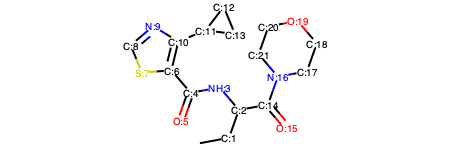

In [29]:
mol